# Covid-19 Analysis and Modeling

## Packages

In [34]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import math
import collections
from tqdm import tqdm
from scipy import stats
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical

# allows us the option to use progress bars for dataframes if we want
tqdm.pandas()

Memory Compression Utils

In [86]:
INT8_MIN = np.iinfo(np.int8).min
INT8_MAX = np.iinfo(np.int8).max
INT16_MIN = np.iinfo(np.int16).min
INT16_MAX = np.iinfo(np.int16).max
INT32_MIN = np.iinfo(np.int32).min
INT32_MAX = np.iinfo(np.int32).max

FLOAT16_MIN = np.finfo(np.float16).min
FLOAT16_MAX = np.finfo(np.float16).max
FLOAT32_MIN = np.finfo(np.float32).min
FLOAT32_MAX = np.finfo(np.float32).max

def memory_usage(data, detail=False):
    """ Displays memory usage """
    memory = data.memory_usage().sum() / (1024 * 1024)
    if detail:
        print("Memory Usage: {0:.2f}MB".format(memory))
        display(data.memory_usage())
    return memory

def compress_dataset(data, verbose=False):
    """ Compresses all the numeric types in a dataset """
    
    memory_usage_before = memory_usage(data)
    
    divider_length = 50
    decimal_length = 2
    
    for col in data.columns:
        col_dtype = data[col][:100].dtype
        after_type = col_dtype
        
        if col_dtype != 'object':
            col_max = data[col].max()
            col_min = data[col].min()
            
            if col_dtype == 'float64':
                if (col_min > FLOAT16_MIN) and (col_max < FLOAT16_MAX):
                    data[col] = data[col].astype(np.float16)
                    after_type = 'float16'
                    
                    
                elif (col_min > FLOAT32_MIN) and (col_max < FLOAT32_MAX):
                    data[col] = data[col].astype(np.float32)
                    after_type = 'float32'
            
            if col_dtype == 'int64':
                if (col_min > INT8_MIN/2) and (col_max < INT8_MAX/2):
                    data[col] = data[col].astype(np.int8)
                    after_type = 'int8'
                elif (col_min > INT16_MIN) and (col_max < INT16_MAX):
                    data[col] = data[col].astype(np.int16)
                    after_type = 'int16'
                elif (col_min > INT32_MIN) and (col_max < INT32_MAX):
                    data[col] = data[col].astype(np.int32)
                    after_type = 'int32'
                    
            if verbose:
                print("Min Value: {0:15s}, Max Value: {1:15s}".format(str(np.round(col_min, decimal_length)), str(np.round(col_max, decimal_length))))
                print(f"Type Change: {col_dtype} -----> {after_type}")
                print(f"Total Memory Compressed: {memory_usage_before - memory_usage(data)}")
                print('='*divider_length)
    
    print(f"Before Compression: {memory_usage_before}")
    print(f"After Total Compression: {memory_usage(data)}")
    return data

## Reading Data

In [4]:
covid_df = pd.read_excel('./Mortality_incidence_sociodemographic_and_clinical_data_in_COVID19_patients.xlsx')
display(covid_df.shape)
covid_df.head()

C:\Users\einma\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


(4711, 85)

,Derivation cohort,LOS_Y,LOS,Death,Age,Severity,Black,White,Asian,Latino,...,Ferritin > 300,CrctProtYes,CrctProtein,C-Reactive Prot > 10,ProCalCYes,Procalcitonin,Procalciton > 0.1,TropYes,Troponin,Troponin > 0.1
0,1,1,1,0,>80,3,0,0,0,0,...,0,1,0.4999,0,0,0.0,0,1,0.01,0
1,1,1,2,1,>60,7,0,1,0,0,...,1,1,14.9000,1,1,0.6,1,1,1.20,1
2,1,1,2,1,>80,7,0,1,0,0,...,1,1,33.9000,1,1,1.2,1,0,0.00,0
3,1,1,15,0,>70,9,1,0,0,0,...,1,1,18.4000,1,1,7.3,1,1,0.05,0
4,1,1,9,0,>70,7,1,0,0,0,...,1,1,11.6000,1,0,0.0,0,1,0.01,0


In [5]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4711 entries, 0 to 4710
Data columns (total 85 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Derivation cohort      4711 non-null   int64  
 1   LOS_Y                  4711 non-null   int64  
 2   LOS                    4711 non-null   int64  
 3   Death                  4711 non-null   int64  
 4   Age                    4711 non-null   object 
 5   Severity               4711 non-null   int64  
 6   Black                  4711 non-null   int64  
 7   White                  4711 non-null   int64  
 8   Asian                  4711 non-null   int64  
 9   Latino                 4711 non-null   int64  
 10  MI                     4711 non-null   int64  
 11  PVD                    4711 non-null   int64  
 12  CHF                    4711 non-null   int64  
 13  CVD                    4711 non-null   int64  
 14  DEMENT                 4711 non-null   int64  
 15  COPD

3 MB isn't too big, but saving memory is always a plus.

In [6]:
covid_df = compress_dataset(covid_df)

Before Compression: 3.0551986694335938
After Total Compression: 0.5212821960449219


In [7]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4711 entries, 0 to 4710
Data columns (total 85 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Derivation cohort      4711 non-null   int8   
 1   LOS_Y                  4711 non-null   int8   
 2   LOS                    4711 non-null   int8   
 3   Death                  4711 non-null   int8   
 4   Age                    4711 non-null   object 
 5   Severity               4711 non-null   int8   
 6   Black                  4711 non-null   int8   
 7   White                  4711 non-null   int8   
 8   Asian                  4711 non-null   int8   
 9   Latino                 4711 non-null   int8   
 10  MI                     4711 non-null   int8   
 11  PVD                    4711 non-null   int8   
 12  CHF                    4711 non-null   int8   
 13  CVD                    4711 non-null   int8   
 14  DEMENT                 4711 non-null   int8   
 15  COPD

In [8]:
covid_df.columns

Index(['Derivation cohort', 'LOS_Y', 'LOS', 'Death', 'Age', 'Severity',
       'Black', 'White', 'Asian', 'Latino', 'MI', 'PVD', 'CHF', 'CVD',
       'DEMENT', 'COPD', 'DM Complicated', 'DM Simple', 'Renal Disease',
       'All CNS', 'Pure CNS', 'Stroke', 'Seizure', 'OldSyncope',
       'OldOtherNeuro', 'OtherBrnLsn', 'Age.1', 'AgeScore', 'O2SatsYes',
       'OsSats', 'O2 Sat < 94', 'TempYes', 'Temp', 'Temp > 38', 'MapYes',
       'MAP', 'MAP < 70', 'DDimerYes', 'Ddimer', 'D-Dimer > 3', 'PltsYes',
       'Plts', 'PltsScore', 'INRYes', 'INR', 'INR > 1.2', 'BUNYes', 'BUN',
       'BUN > 30', 'CrtnYes', 'Creatinine', 'CrtnScore', 'SodimuYes', 'Sodium',
       'Sodium < 139 or > 154', 'GlucoseYese', 'Glucose',
       'Glucose <60 or > 500', 'ASTYes', 'AST', 'AST > 40', 'ALTYes', 'ALT',
       'ALT > 40', 'WBCYes', 'WBC', 'WBC <1.8 or > 4.8', 'LymphoYes', 'Lympho',
       'Lymphocytes < 1', 'IL6Yes', 'IL6', 'IL6 > 150', 'FerritinYes',
       'Ferritin', 'Ferritin > 300', 'CrctProtYes', 'Crc

## EDA

Some column names and their meanings: <br>
&emsp; LOS: Length of stay at hospital <br>
&emsp; Death: Whether or not the patient died <br>
&emsp; Severity: The severity of the COVID-19 symptoms (on a weird scale from 0-11) <br>
&emsp; Black-Latino: Patient Demographics <br>
&emsp; MI: Miocardial Infraction <br>
&emsp; PVD: Peripheral vascular disease <br>
&emsp; CHF: Congestive Heart Failure <br>
&emsp; CVD: Cardiovascular Disease <br>
&emsp; Dement: Dementia <br>
&emsp; COPD: Chronic obstructive pulmonary disease <br>
&emsp; DM Simple: Diabetes mellitus simple <br>
&emsp; DM Complicated: Diabetes mellitus complicated <br> 
&emsp; OsSats: Oxygen Saturation <br> 
&emsp; MAP: Mean arterial pressure <br>
&emsp; Ddimer: D-dimer <br>
&emsp; Plts: Platelets <br>
&emsp; INR: International Normalized Ratio <br>
&emsp; BUN: Blood Urea Nitrogren <br>
&emsp; AST: Alanine Aminotransferase <br>
&emsp; WBC: White Blood Cell count <br>
&emsp; IL-6: Interleukin-6


In [9]:
covid_df.describe()

,Derivation cohort,LOS_Y,LOS,Death,Severity,Black,White,Asian,Latino,MI,...,Ferritin > 300,CrctProtYes,CrctProtein,C-Reactive Prot > 10,ProCalCYes,Procalcitonin,Procalciton > 0.1,TropYes,Troponin,Troponin > 0.1
count,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,...,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000
mean,0.499682,0.927616,7.160263,0.243685,3.586287,0.369985,0.098917,0.025685,0.372108,0.042666,...,0.543621,0.836128,10.320312,0.393335,0.655487,1.584961,0.365952,0.863935,0.051544,0.095521
std,0.500053,0.259150,7.029782,0.429350,2.289303,0.482852,0.298583,0.158209,0.483418,0.202125,...,0.498146,0.370198,11.218750,0.488542,0.475260,6.261719,0.481747,0.342893,0.268066,0.293965
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.899902,0.000000,0.000000,0.000000,0.000000,1.000000,0.010002,0.000000
50%,0.000000,1.000000,5.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,6.500000,0.000000,1.000000,0.099976,0.000000,1.000000,0.010002,0.000000
75%,1.000000,1.000000,9.000000,0.000000,5.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,16.000000,1.000000,1.000000,0.399902,1.000000,1.000000,0.020004,0.000000
max,1.000000,1.000000,56.000000,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,100.000000,1.000000,1.000000,50.000000,1.000000,1.000000,9.562500,1.000000


Checking for missing values in any of the columns.

In [10]:
sums = covid_df.isna().sum()
display(sums)
print("\n\nCols with missing vals: ")
sums[sums > 0]

Derivation cohort    0
LOS_Y                0
LOS                  0
Death                0
Age                  0
                    ..
Procalcitonin        0
Procalciton > 0.1    0
TropYes              0
Troponin             0
Troponin > 0.1       0
Length: 85, dtype: int64



Cols with missing vals: 


Series([], dtype: int64)

## Questions

1. Is Covid-19 more severe for older people vs. younger people?
2. Does Covid-19 differ in severity for different ethnicities?
3. Are certain symptoms or conditions more associated with death from Covid-19?
4. Can we predict the severity of Covid-19 from these conditions?
5. Can we predict whether or not a patient will die from the same conditions?

## Question 1 

<AxesSubplot:title={'center':'Age Distribution'}, ylabel='Age.1'>

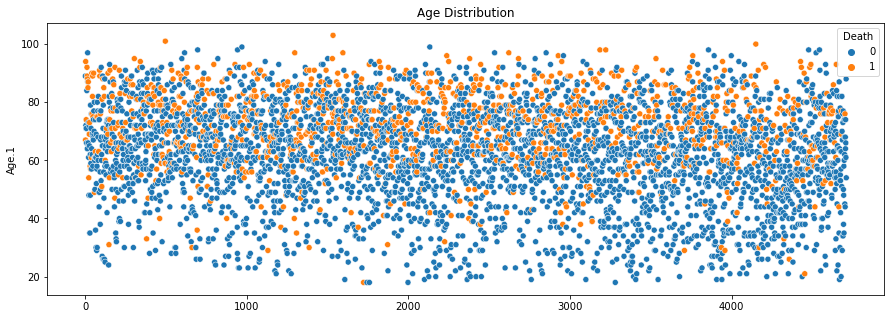

In [10]:
plt.figure(figsize=(15, 5))
plt.title("Age Distribution")
sns.scatterplot(x=covid_df.index, y=covid_df['Age.1'], hue=covid_df.Death)

<AxesSubplot:title={'center':'% of Deaths by Age Category'}, xlabel='Age'>

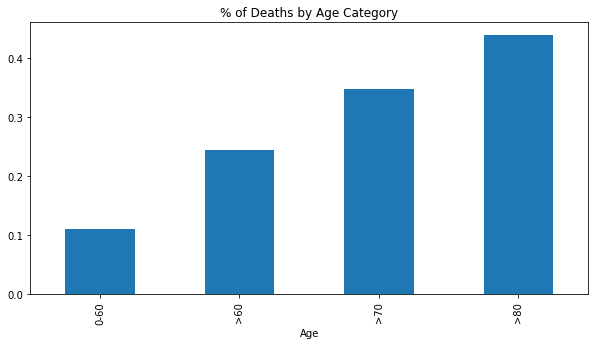

In [11]:
deaths_by_age = covid_df.groupby('Age').sum()['Death'] / covid_df.groupby('Age').count()['Death']
plt.figure(figsize=(10, 5))
deaths_by_age.plot.bar(title="% of Deaths by Age Category")

From these two plots, we can see that deaths from Covid-19 generally occur in the elderly with people over 80 accounting for over 40% of the deaths. <br>
People below 60 account for about 10%.

## Question 2

We can probably do an ANOVA test using the severities for each race. (We're gonna bin the values of severity later, but for now, we'll use the original values)

In [12]:
black_severities = covid_df[covid_df['Black'] == 1].loc[:, 'Severity']
white_severities = covid_df[covid_df['White'] == 1].loc[:, 'Severity']
asian_severities = covid_df[covid_df['Asian'] == 1].loc[:, 'Severity']
latino_severities = covid_df[covid_df['Latino'] == 1].loc[:, 'Severity']

print("Black severities: ", black_severities.shape)
print("White severities: ", white_severities.shape)
print("Asian severities: ", asian_severities.shape)
print("Latino severities: ", latino_severities.shape)

Black severities:  (1743,)
White severities:  (466,)
Asian severities:  (121,)
Latino severities:  (1753,)


In [13]:
fvalue, pvalue = stats.f_oneway(black_severities, white_severities, asian_severities, latino_severities)
print("f-value: ", fvalue)
print("p-value: ", pvalue)

f-value:  7.397834258892498
p-value:  6.111418721635158e-05


With this ANOVA test, our null hypothesis is that the mean of the severity of all the groups is the same. <br>
Since our p-value is below 0.05, we can reject this hypothsis with high confidence and say that at least two <br> 
of our groups have significant differences when it comes to ethnicity and Covid-19 severity. 

We can also plot the deaths between difference ethnicities.

Total number of deaths:  1148.0
Percentage of Blacks in dataset:  37.0
Percentage of Blacks who died:  23.41
Percentage of overall deaths:  35.54


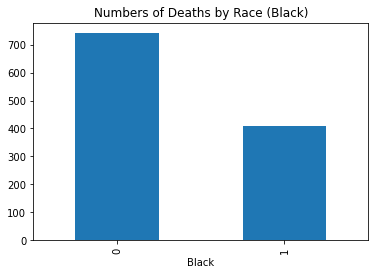

In [14]:
deaths_grouped = covid_df.groupby('Black').sum()['Death']
total_race = covid_df.groupby('Black').count()['Death']
percentage_race_in_data = np.round(total_race[1] / total_race.sum(), 4) * 100
num_deaths = deaths_grouped[1]

print("Total number of deaths: ", deaths_grouped.sum())
print("Percentage of Blacks in dataset: ", percentage_race_in_data)
print("Percentage of Blacks who died: ", np.round(num_deaths / total_race[1], 4) * 100)
print("Percentage of overall deaths: ", np.round(num_deaths / deaths_grouped.sum(), 4) * 100)
graph = deaths_grouped.plot.bar(title='Numbers of Deaths by Race (Black)')
var = graph.set_xticklabels(graph.get_xticklabels(), rotation=90)

Total number of deaths:  1148.0
Percentage of Whites in dataset:  9.89
Percentage of Whites who died:  28.76
Percentage of overall deaths:  11.67


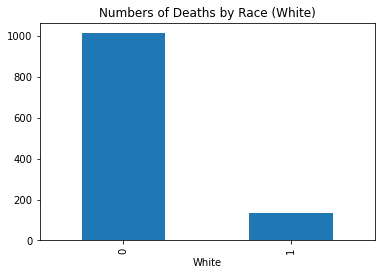

In [15]:
deaths_grouped = covid_df.groupby('White').sum()['Death']
total_race = covid_df.groupby('White').count()['Death']
percentage_race_in_data = np.round(total_race[1] / total_race.sum(), 4) * 100
num_deaths = deaths_grouped[1]

print("Total number of deaths: ", deaths_grouped.sum())
print("Percentage of Whites in dataset: ", percentage_race_in_data)
print("Percentage of Whites who died: ", np.round(num_deaths / total_race[1], 4) * 100)
print("Percentage of overall deaths: ", np.round(num_deaths / deaths_grouped.sum(), 4) * 100)
graph = deaths_grouped.plot.bar(title='Numbers of Deaths by Race (White)')
var = graph.set_xticklabels(graph.get_xticklabels(), rotation=90)

Total number of deaths:  1148.0
Percentage of Asians in dataset:  2.5700000000000003
Percentage of Asians who died:  31.4
Percentage of overall deaths:  3.3099999999999996


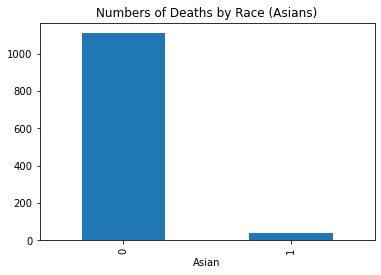

In [16]:
deaths_grouped = covid_df.groupby('Asian').sum()['Death']
total_race = covid_df.groupby('Asian').count()['Death']
percentage_race_in_data = np.round(total_race[1] / total_race.sum(), 4) * 100
num_deaths = deaths_grouped[1]

print("Total number of deaths: ", deaths_grouped.sum())
print("Percentage of Asians in dataset: ", percentage_race_in_data)
print("Percentage of Asians who died: ", np.round(num_deaths / total_race[1], 4) * 100)
print("Percentage of overall deaths: ", np.round(num_deaths / deaths_grouped.sum(), 4) * 100)
graph = deaths_grouped.plot.bar(title='Numbers of Deaths by Race (Asians)')
var = graph.set_xticklabels(graph.get_xticklabels(), rotation=90)

Total number of deaths:  1148.0
Percentage of Latinos in dataset:  37.21
Percentage of Latinos who died:  23.1
Percentage of overall deaths:  35.28


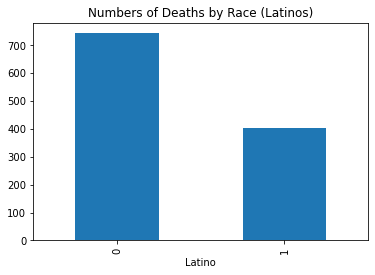

In [17]:
deaths_grouped = covid_df.groupby('Latino').sum()['Death']
total_race = covid_df.groupby('Latino').count()['Death']
percentage_race_in_data = np.round(total_race[1] / total_race.sum(), 4) * 100
num_deaths = deaths_grouped[1]

print("Total number of deaths: ", deaths_grouped.sum())
print("Percentage of Latinos in dataset: ", percentage_race_in_data)
print("Percentage of Latinos who died: ", np.round(num_deaths / total_race[1], 4) * 100)
print("Percentage of overall deaths: ", np.round(num_deaths / deaths_grouped.sum(), 4) * 100)
graph = deaths_grouped.plot.bar(title='Numbers of Deaths by Race (Latinos)')
var = graph.set_xticklabels(graph.get_xticklabels(), rotation=90)

## Predicting Death

These last two questions can be answered through predictive modeling.

As an additional insight, I'd like to see the performance difference between KNN and something more sophisticated like XGBoost.

### KNN

In [11]:
class KNN():
    """
    My own implementation of K-nearest neighbors algorithm.
    """
    def __init__(self, data: pd.DataFrame, k: int, label_col: str, similarity: str='cosine'):
        self.data_with_label = data
        self.data_without_label = data.loc[:, data.columns != label_col]
        self.k = k
        self.label_col = label_col
        
        # this is mostly if we want to implement other similarity measures later
        self.similarity = similarity
        
    def predict(self, x: pd.Series):
        """ Returns the predicted label for certain entry. X is assumed to not be in the data. """
        sims = self.get_similarity_scores(x, self.data_without_label)
        neighbors = self.get_nearest_neighbors(sims, self.k)
        
        return neighbors[self.label_col].mode().iloc[0]
        
    
    def get_nearest_neighbors(self, similarities: pd.Series, k: int):
        """ Returns a dataframe with the k nearest neighbors. """
        # sorting the similarities
        similarities = similarities.sort_values()
        most_similar_indices = similarities.index[:k]
        return self.data_with_label.loc[most_similar_indices]
        
        
    def get_similarity_scores(self, x: pd.Series, data: pd.DataFrame):
        """ Returns a dataframe with the cosine similarities of all the entries in the data. """
        x = x.to_numpy()
        top = x * data
        # tranposing the matrix so I can sum each row by treating it as a column
        top_sums = top.T.apply(lambda col: col.sum())
        
        # denominator
        data_lens = data ** 2
        data_lens = data_lens.T.sum()
        data_lens = data_lens.apply(math.sqrt)
        
        x_len = math.sqrt((x ** 2).sum())
        denom = x_len * data_lens
        
        return top_sums / denom

#### Normalizing and One-Hot Encoding

In [12]:
def normalize_data(data: pd.DataFrame, label_col: str):
    """ Normalizes data between 0 and 1 """
    data_no_label = data.loc[:, data.columns != label_col]
    normalized_data = data_no_label.progress_apply(lambda col: (col - col.min()) / (col.max() - col.min()))
    normalized_data[label_col] = data[label_col]
    return normalized_data

In [13]:
def get_accuracy(preds: list, actuals: pd.Series):
    """ Computes the accuracy of the predictions """
    correct = (preds == actuals)
    num_correct = correct.sum()
    return num_correct / correct.count()

The Age column is the only categorical column, and it's probably very useful so we're going to one-hot encode it. <br>
It'll create 3 extra features in our data, but that shouldn't be a bad thing for either of our models. 

In [14]:
covid_df = pd.get_dummies(covid_df, columns=['Age'])

We have the normalize the features here because cosine similarity is sensitive to large values. 

In [15]:
normalized_covid_data = normalize_data(covid_df, 'Death')
normalized_covid_data.head()

100%|██████████| 87/87 [00:00<00:00, 3503.37it/s]


,Derivation cohort,LOS_Y,LOS,Severity,Black,White,Asian,Latino,MI,PVD,...,Procalcitonin,Procalciton > 0.1,TropYes,Troponin,Troponin > 0.1,Age_0-60,Age_>60,Age_>70,Age_>80,Death
0,1.0,1.0,0.017857,0.272727,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,1.0,0.001046,0.0,0.0,0.0,0.0,1.0,0
1,1.0,1.0,0.035714,0.636364,0.0,1.0,0.0,0.0,0.0,0.5,...,0.012001,1.0,1.0,0.125488,1.0,0.0,1.0,0.0,0.0,1
2,1.0,1.0,0.035714,0.636364,0.0,1.0,0.0,0.0,0.0,0.5,...,0.024002,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,1
3,1.0,1.0,0.267857,0.818182,1.0,0.0,0.0,0.0,1.0,0.0,...,0.145996,1.0,1.0,0.005226,0.0,0.0,0.0,1.0,0.0,0
4,1.0,1.0,0.160714,0.636364,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,1.0,0.001046,0.0,0.0,0.0,1.0,0.0,0


#### K-Fold Validation

In [28]:
skf = StratifiedKFold(n_splits=5)

# first thing we're trying to predict is death
target_lab = 'Death'
target = normalized_covid_data.loc[:, target_lab]

fold_num = 1
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
best_fold = -1
best_k = -1
best_accuracy = -1

# accuracies will be indexed by fold number then k_value
accuracies = collections.defaultdict(dict)

for train_index, test_index in skf.split(normalized_covid_data, target):
    print(f"Fold #{fold_num}")
    train_data = normalized_covid_data.loc[train_index, :]
    test_data = normalized_covid_data.loc[test_index, :]
    for k in k_values:
        knn = KNN(train_data, k, target_lab)
        predictions = []
        for ind in tqdm(test_data.index):
            row = test_data.loc[ind, test_data.columns != target_lab]
            predictions.append(knn.predict(row))
        
        accuracy = get_accuracy(predictions, test_data[target_lab])
        accuracies[fold_num][k] = accuracy
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k
            best_fold = fold_num
            
    fold_num += 1
    
print("Best accuracy: ", best_accuracy)
print("Best K-value: ", best_k)
print("Best Fold: ", best_fold)

Fold #1


100%|██████████| 943/943 [02:23<00:00,  6.57it/s]


Fold #2


100%|██████████| 942/942 [02:23<00:00,  6.55it/s]


Fold #3


100%|██████████| 942/942 [02:23<00:00,  6.56it/s]


Fold #4


100%|██████████| 942/942 [02:24<00:00,  6.54it/s]


Fold #5


100%|██████████| 942/942 [02:24<00:00,  6.54it/s]

Best accuracy:  0.7579617834394905
Best K-value:  2
Best Fold:  6


In [33]:
# getting the best data split and accuracy
index = 1
best_train_index = None
best_test_index = None
for train_index, test_index in skf.split(normalized_covid_data, target):
    if index == 3:
        best_train_index = train_index
        best_test_index = test_index
        break
    index += 1
        
# getting the best accuracy 
train_data = normalized_covid_data.loc[best_train_index, :]
test_data = normalized_covid_data.loc[best_test_index, :]        
predictions = []
knn_best = KNN(train_data, best_k, target_lab)
for ind in tqdm(test_data.index):
    row = test_data.loc[ind, test_data.columns != target_lab]
    predictions.append(knn.predict(row))

accuracy = get_accuracy(predictions, test_data[target_lab])
accuracy

100%|██████████| 942/942 [02:26<00:00,  6.44it/s]


0.7569002123142251

KNN seems to work best when we use a K value of 2. We are able to achieve a 76% accuracy when predicting death. <br>
Below is a confusion matrix of our predictions.

In [48]:
mat = confusion_matrix(test_data[target_lab], predictions)
display(pd.DataFrame(mat))
print("Actuals: Rows")
print("Predictions: Columns")
print("0 = No Death")
print("1 = Death")

,0,1
0,713,0
1,229,0


Actuals: Rows
Predictions: Columns
0 = No Death
1 = Death


Looks like our KNN model does decently if it predicts all living in our data split. Let's see if XGBoost can create a better separation.

### XGBoost

In [17]:
# xgboost doesn't work with certain characters in the column names
target_lab = 'Death'
xg_covid_df = covid_df.copy()
xg_covid_df.columns = [col.replace('<', 'less than').replace('>', 'greater than ').replace('  ', ' ') for col in xg_covid_df.columns]

x = xg_covid_df.loc[:, xg_covid_df.columns != target_lab]
y = xg_covid_df.loc[:, target_lab]

Splitting the data into test and train and creating data matrices to feed into the model.

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1234)
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dtest = xgb.DMatrix(data=x_test, label=y_test)

Setting hyperparameters and training the model.

In [19]:
params = {"objective": "binary:logistic", "colsample_bytree": 0.3, "learning_rate": 0.1, "max_depth": 5}
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

Computing accuracy and confusion matrix.

In [20]:
xgb_preds = xgb_model.predict(dtest)
xgb_preds = [1 if pred >= 0.5 else 0 for pred in xgb_preds]
accuracy = get_accuracy(xgb_preds, y_test)
print("XGBoost Accuracy: ", accuracy)
xgb_mat = confusion_matrix(y_test, xgb_preds)
display(pd.DataFrame(xgb_mat))

XGBoost Accuracy:  0.8525980911983033


,0,1
0,682,41
1,98,122


XGBoost does significantly better at predicting death than KNN. It could also possibly perform better if we spent more time doing hyperparameter tuning. 

XGBoost also allows us to see the importance of each feature, which we can plot below.

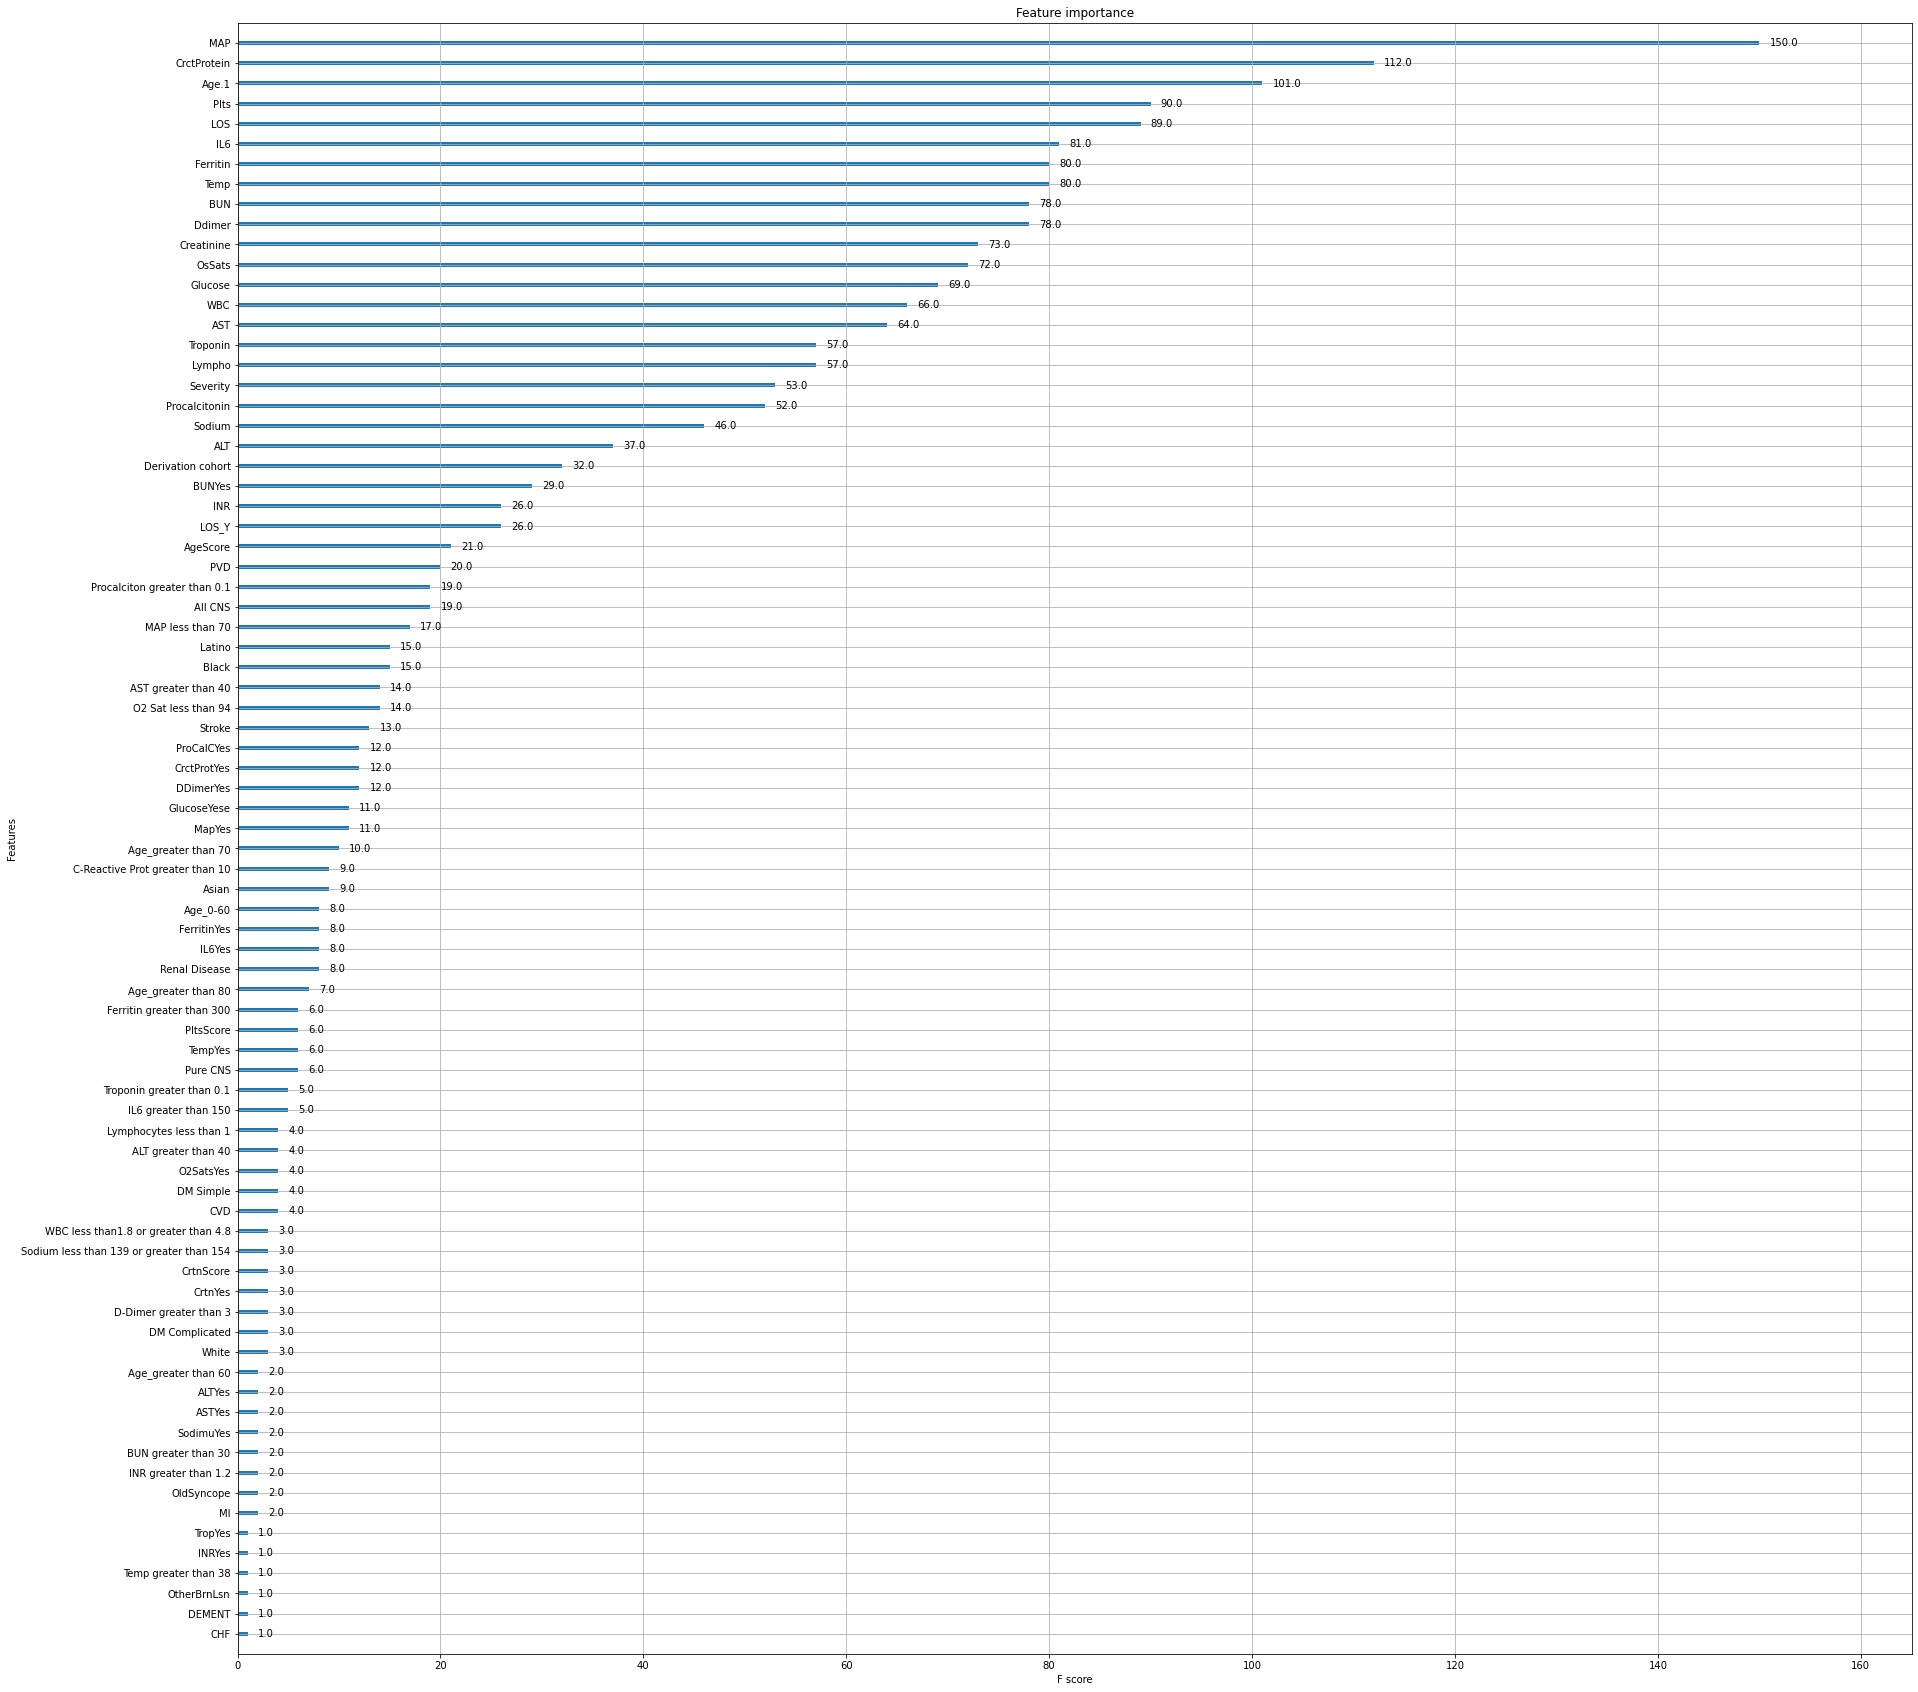

In [22]:
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [30, 30]
plt.show()

Mean Arterial Pressure, CrctProtein, and your Age are the 3 most significant predictors of death when diagnosed with Covid-19. <br>
Surprisingly, severity isn't in the top ten.

## Predicting Severity

For the most part, we'll be doing the same thing for predicting severity with a few changes.

### Binning Severity

The severity column contains values from 0-11, which doesn't really make sense to me. To make this a bit easier on the classifier, <br>
I'm going to bin the values into 'Mild', 'Moderate', and 'Severe' symptom classes. So 0-3 = Mild, 4-7 = Moderate, and 8-11 = Severe.

In [85]:
def convert_severity(x: int) -> int:
    mild = list(range(0, 4))
    moderate = list(range(4, 8))
    severe = list(range(8, 12))
    
    if x in mild:
        return 0
    elif x in moderate:
        return 1
    # has to be in severe category
    return 2

Binning the severity values.

In [83]:
sev_df = covid_df.copy()
display(sev_df['Severity'].value_counts())

3     806
2     729
4     728
5     554
1     537
6     395
0     390
7     305
8     155
9      75
10     27
11     10
Name: Severity, dtype: int64

In [84]:
sev_df['Severity'] = sev_df['Severity'].apply(convert_severity)
display(sev_df['Severity'].value_counts())

0    2462
1    1982
2     267
Name: Severity, dtype: int64

Distribution of the labels after converting them.

<BarContainer object of 3 artists>

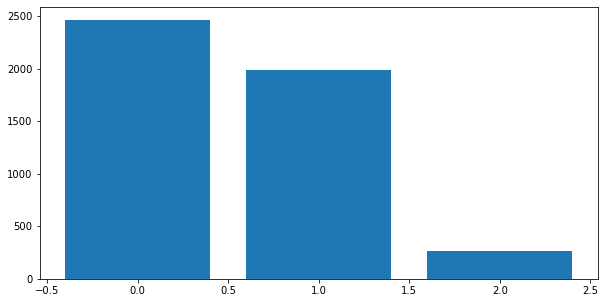

In [50]:
counts = collections.Counter(sev_df['Severity'])
plt.figure(figsize=(10, 5))
plt.bar(counts.keys(), counts.values()) 

We definitely have class imbalance with very few severe cases.

### KNN

Normalizing and transforming labels (again)

In [51]:
normalized_sev_df = normalize_data(sev_df, 'Severity')
normalized_sev_df.head()

100%|██████████| 87/87 [00:00<00:00, 3478.16it/s]


,Derivation cohort,LOS_Y,LOS,Death,Black,White,Asian,Latino,MI,PVD,...,Procalcitonin,Procalciton > 0.1,TropYes,Troponin,Troponin > 0.1,Age_0-60,Age_>60,Age_>70,Age_>80,Severity
0,1.0,1.0,0.017857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,1.0,0.001046,0.0,0.0,0.0,0.0,1.0,0
1,1.0,1.0,0.035714,1.0,0.0,1.0,0.0,0.0,0.0,0.5,...,0.012001,1.0,1.0,0.125488,1.0,0.0,1.0,0.0,0.0,1
2,1.0,1.0,0.035714,1.0,0.0,1.0,0.0,0.0,0.0,0.5,...,0.024002,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,1
3,1.0,1.0,0.267857,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.145996,1.0,1.0,0.005226,0.0,0.0,0.0,1.0,0.0,2
4,1.0,1.0,0.160714,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,1.0,0.001046,0.0,0.0,0.0,1.0,0.0,1


#### K-Fold Validation

In [52]:
sev_skf = StratifiedKFold(n_splits=3)

# now we're predicting severity
sev_target_lab = 'Severity'
sev_target = normalized_sev_df.loc[:, sev_target_lab]

sev_fold_num = 1
sev_k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10,]

sev_best_fold = -1
sev_best_k = -1
sev_best_accuracy = -1

# accuracies will be indexed by fold number then k_value
sev_accuracies = collections.defaultdict(dict)

for train_index, test_index in sev_skf.split(normalized_sev_df, sev_target):
    print(f"Fold #{sev_fold_num}")
    train_data = normalized_sev_df.loc[train_index, :]
    test_data = normalized_sev_df.loc[test_index, :]
    for k in sev_k_values:
        knn = KNN(train_data, k, sev_target_lab)
        predictions = []
        for ind in tqdm(test_data.index):
            row = test_data.loc[ind, test_data.columns != sev_target_lab]
            predictions.append(knn.predict(row))
        
        accuracy = get_accuracy(predictions, test_data[sev_target_lab])
        sev_accuracies[sev_fold_num][k] = accuracy
        
        if accuracy > sev_best_accuracy:
            sev_best_accuracy = accuracy
            sev_best_k = k
            sev_best_fold = sev_fold_num
            
    sev_fold_num += 1
    
print("Best accuracy: ", sev_best_accuracy)
print("Best K-value: ", sev_best_k)
print("Best Fold: ", sev_best_fold)

Fold #1


100%|██████████| 1571/1571 [03:29<00:00,  7.51it/s]


Fold #2


100%|██████████| 1570/1570 [03:29<00:00,  7.48it/s]


Fold #3


100%|██████████| 1570/1570 [03:27<00:00,  7.55it/s]

Best accuracy:  0.5194143857415658
Best K-value:  2
Best Fold:  1


In [55]:
# getting the best data split and accuracy
sev_index = 1
best_sev_train_index = None
best_sev_test_index = None

for train_index, test_index in sev_skf.split(normalized_sev_df, sev_target):
    if sev_index == sev_best_fold:
        best_sev_train_index = train_index
        best_sev_test_index = test_index
        break
    sev_index += 1
        
# getting the best accuracy 
sev_train_data = normalized_sev_df.loc[best_sev_train_index, :]
sev_test_data = normalized_sev_df.loc[best_sev_test_index, :]        
sev_predictions = []
sev_knn_best = KNN(sev_train_data, sev_best_k, sev_target_lab)

for ind in tqdm(sev_test_data.index):
    row = sev_test_data.loc[ind, sev_test_data.columns != sev_target_lab]
    sev_predictions.append(knn.predict(row))

accuracy = get_accuracy(sev_predictions, sev_test_data[sev_target_lab])
accuracy

100%|██████████| 1571/1571 [03:27<00:00,  7.55it/s]


0.5187778485041374

Predicting severity is a bit more challenging. 52% accuracy is still better than guessing though. 

### XGBoost

This is all pretty much the same as before. The only difference is that instead of predicting a binary <br>
class, we're predicting 3 classes, so we need to use 'softprob' in our XGBoost classifier.

In [70]:
# xgboost doesn't work with certain characters in the column names
sev_target_lab = 'Severity'
xg_sev_df = covid_df.copy()
xg_sev_df.columns = [col.replace('<', 'less than').replace('>', 'greater than ').replace('  ', ' ') for col in xg_sev_df.columns]
xg_sev_df['Severity'] = xg_sev_df['Severity'].apply(convert_severity)

sev_x = xg_sev_df.loc[:, xg_sev_df.columns != sev_target_lab]
sev_y = xg_sev_df.loc[:, sev_target_lab]

In [72]:
x_train, x_test, y_train, y_test = train_test_split(sev_x, sev_y, test_size=0.2, random_state=1234)
sev_dtrain = xgb.DMatrix(data=x_train, label=y_train)
sev_dtest = xgb.DMatrix(data=x_test, label=y_test)

In [79]:
sev_params = {"objective": "multi:softprob", "num_class": 3, "colsample_bytree": 0.3, "learning_rate": 0.1, "max_depth": 5}
xgb_sev_model = xgb.train(sev_params, sev_dtrain, num_boost_round=100)

In [81]:
xgb_sev_preds = xgb_sev_model.predict(sev_dtest)
xgb_sev_preds = [np.argmax(pred_array) for pred_array in xgb_sev_preds]
accuracy = get_accuracy(xgb_sev_preds, y_test)
print("XGBoost Accuracy: ", accuracy)
xgb_sev_mat = confusion_matrix(y_test, xgb_sev_preds)
display(pd.DataFrame(xgb_sev_mat))

XGBoost Accuracy:  0.9597030752916225


,0,1,2
0,473,15,0
1,6,399,0
2,0,17,33


KNN doesn't perform very well, but XGBoost does outstanding with severity prediction. 

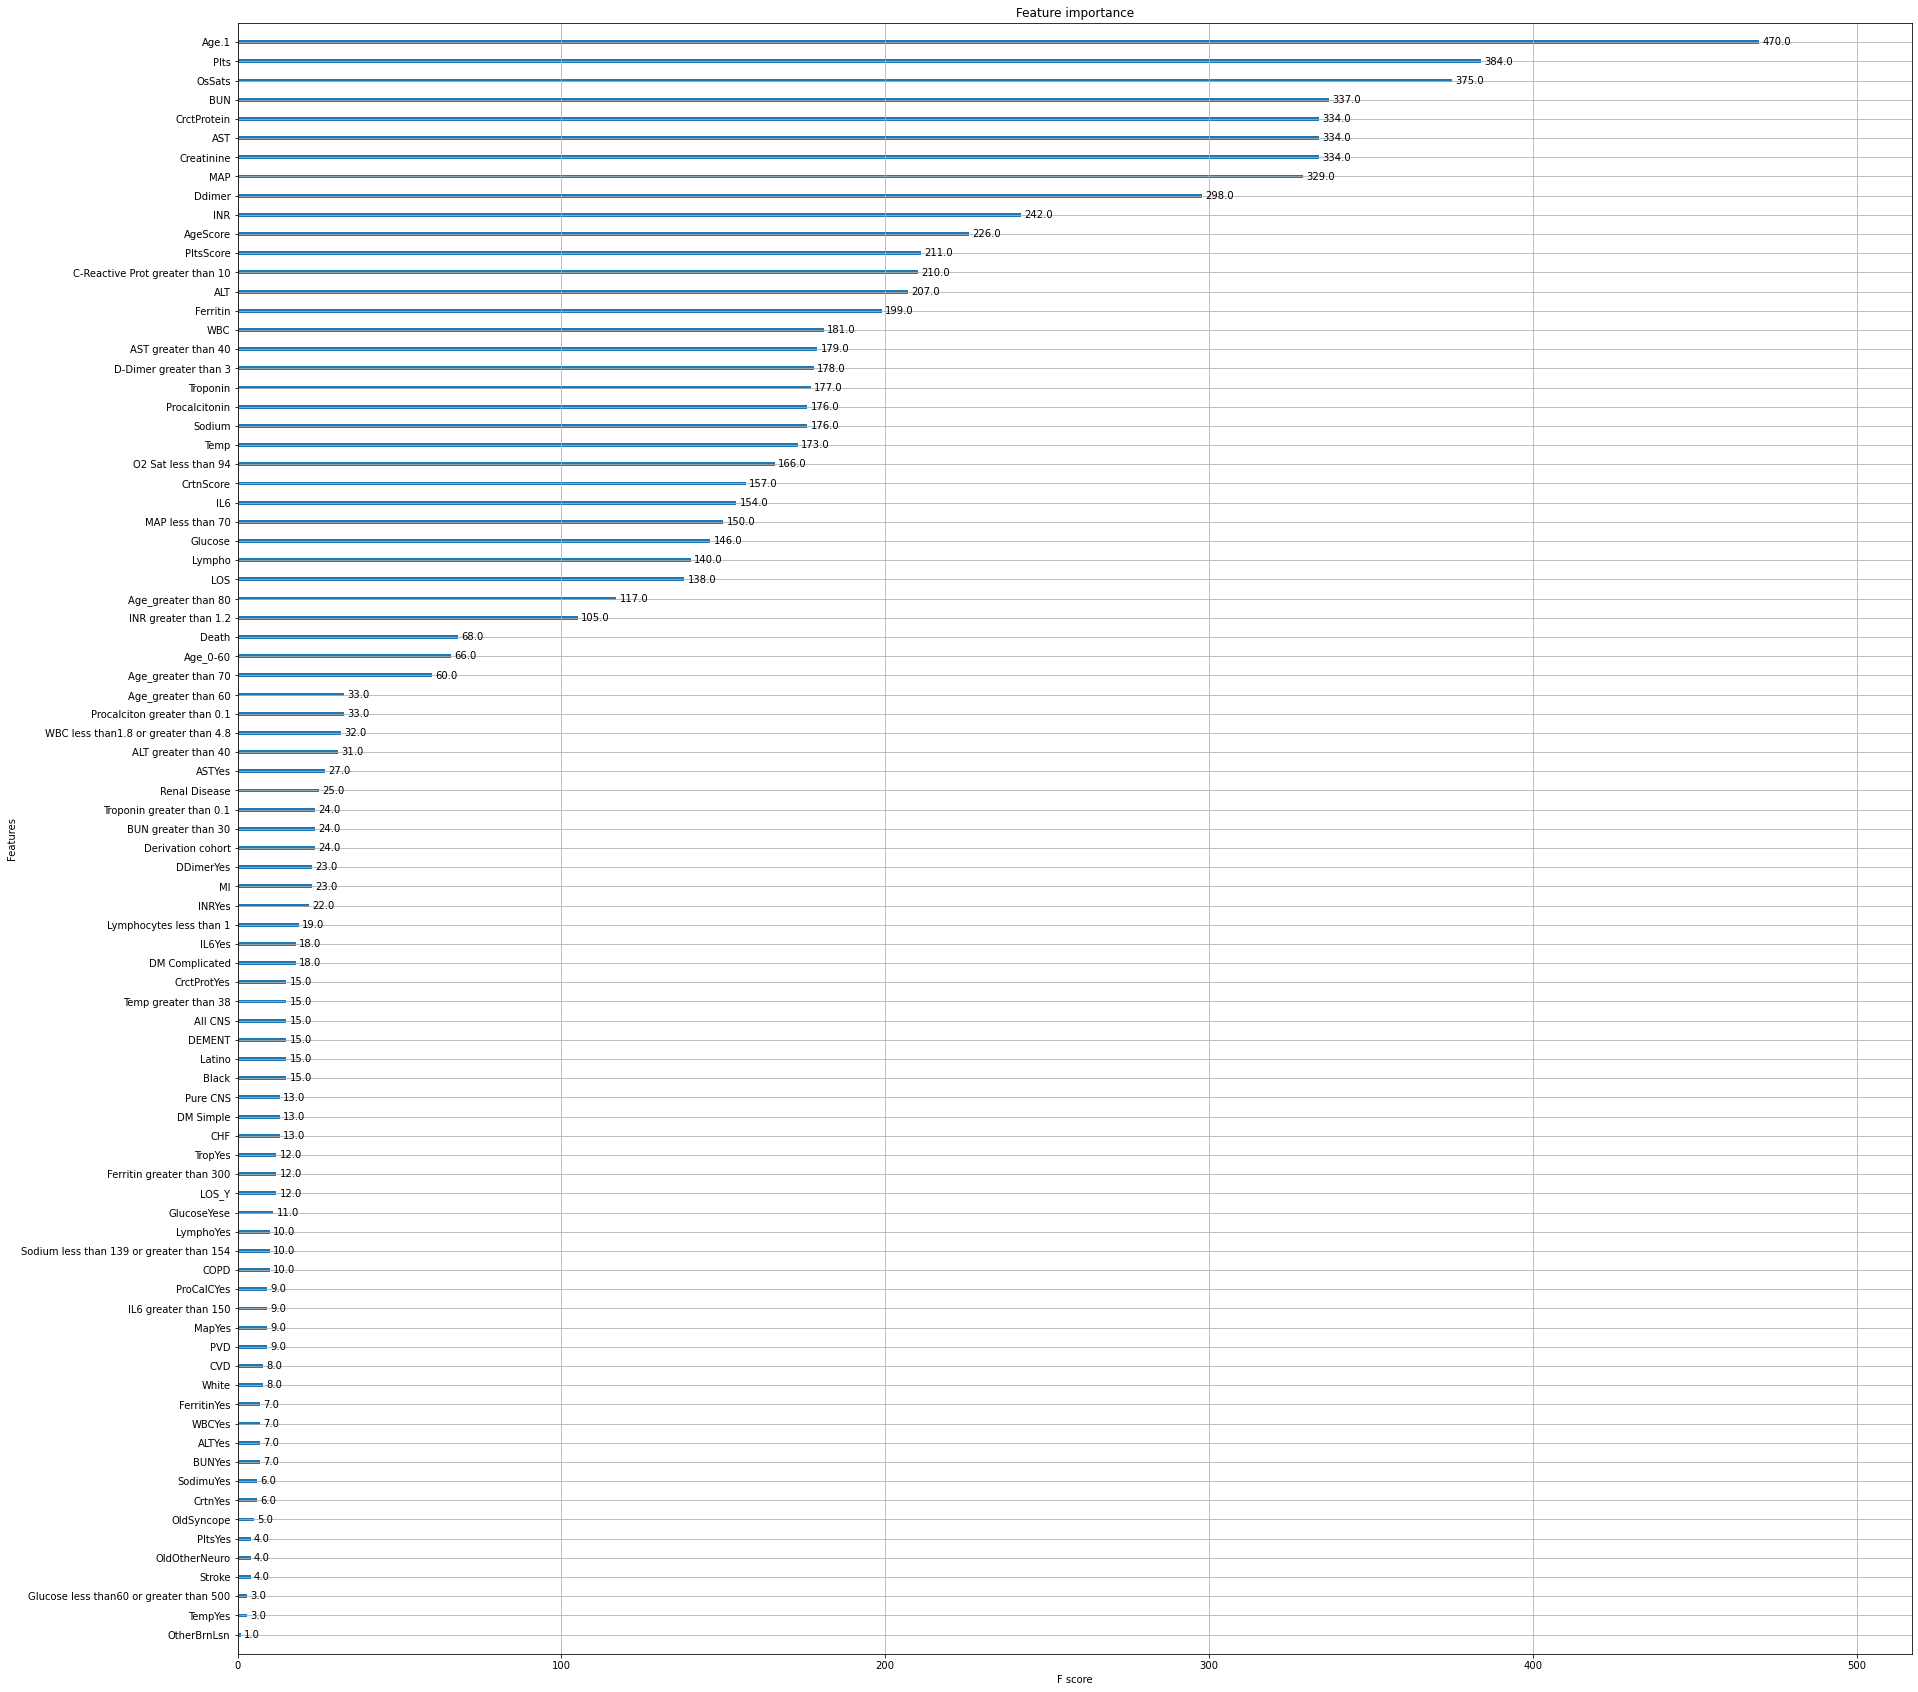

In [82]:
xgb.plot_importance(xgb_sev_model)
plt.rcParams['figure.figsize'] = [30, 30]
plt.show()

Turns out that your age is the number one factor in determining how harsh your symptoms of Covid-19 are going to be. <br>
This aligns with what the medical experts warned during the pandemic, that generally the older you were the more dangerous <br>
Covid tended to be for you.